# 第六章：Gibbs采样器与后验近似
Dreisteine, 2021.08.01

## 一、问题背景

多参数模型的后验分布往往非标准化且难以直接进行采样，于是通常考虑对各个参数分别从其条件分布中进行采样。这样便可**使用Gibbs采样器对后验分布进行近似：使用迭代的方式构造一组独立的参数值序列，对应的分布收敛于对应的目标联合分布**。

在上一章中我们提到，对正态分布的均值$\theta$随方差$\sigma^2$的条件概率密度先验估计为(**重要内容**)：

$$
\color{red}{p(\theta|\sigma^2) = \text{dnorm}(\theta, \mu_0, \sigma/\sqrt{\kappa_0})}
$$

其中$\mu_0$为先验观测样本均值，$\kappa_0$为先验观测样本数，$\sigma$为标准差。在某些情形下这种处理时有意义的，但在其他情况下，我们可能希望$\theta$的不确定性独立于$\sigma^2$，这样一来$p(\theta,\sigma^2)=p(\theta)\times p(\sigma^2)$，基于此的一种联合分布便是如下的半共轭先验分布：

$$
\begin{aligned}
\theta & \sim \text{normal}\left(\mu_0, \tau_0^2 \right) \\
1/\sigma^2 & \sim \text{gamma}(\nu_0/2, \nu_0\sigma_0^2/2)
\end{aligned}
$$



**注意**：<u>这里$\tau_0^2$是均值$\theta$先验分布方差，与$\sigma^2$无关，在第五章中我们认为$\tau_0^2$与$\sigma^2$有关，因此$\tau_0^2 = \left(\frac{\sigma}{\sqrt{\kappa_0}}\right)^2$，不要混淆</u>。

如果对于一批观测样本$\{Y_1,...,Y_n\}|\theta, \sigma^2 \sim \text{i.i.d. normal}(\theta, \sigma^2)$，我们在上一章5.2节中得到对$\theta$的后验估计为：

$$
\left\{\theta|\sigma, y_1,...,y_n\right\} \sim \text{normal}(\mu_n, \tau_n^2)
$$

当假设$\tau_0^2$正比于$\sigma^2$时，$p(\sigma^2|y_1,...,y_n)$为inverse-gamma分布。然后便可采用Monte-Carlo方法进行采样，此处不再赘述。但是若$\tau_0^2$正比于$\sigma^2$的假设不成立，那么$p(\sigma^2|y_1,...,y_n)$不符合inverse-gamma等其他易求解的标准分布。

## 二、离散近似

令$\tilde{\sigma}^2=1/\sigma^2$，由贝叶斯公式易知：

$$
\begin{aligned}
\frac{p(\theta_1,\tilde \sigma_1^2)|y_1,...,y_n}{p(\theta_2,\tilde \sigma_2^2)|y_1,...,y_n} & = \frac{p(\theta_1,\tilde \sigma_1^2,y_1,...,y_n)/p(y_1,...,y_n)}{p(\theta_2,\tilde \sigma_2^2,y_1,...,y_n)/p(y_1,...,y_n)} \\
& = \frac{p(\theta_1,\tilde \sigma_1^2,y_1,...,y_n)}{p(\theta_2,\tilde \sigma_2^2,y_1,...,y_n)}
\end{aligned}
$$

上述联合分布是很容易计算的：

$$
\begin{aligned}
p(\theta,\tilde \sigma^2,y_1,...,y_m) & = p(\theta, \tilde \sigma^2) \times p(y_1,...,y_n|\theta, \tilde \sigma^2) \\
    & = \text{dnorm}\left(\theta, \mu_0, \tau_0^2\right) \times \text{dgamma}(\tilde \sigma^2, \nu_0/2, \nu_0\sigma_0^2/2) \times \prod_{i=1}^{n}\text{dnorm}(y_i, \theta, 1/\sqrt{\tilde \sigma^2})
\end{aligned}
$$

我们可以基于上述相对后验概率，在一个参数网格中构造后验分布。令$\{\theta_1,...,\theta_G\}$，$\{\tilde \sigma_1^2, ..., \tilde \sigma_H^2\}$为(均匀地？)离散化的参数网格点坐标序列，对于其中的每个网格点$\{\theta_k, \tilde \sigma_l\}$，计算后验分布近似值(推导简单，此处略)：

$$
\begin{aligned}
p_D(\theta_k, \tilde \sigma_l^2|y_1,...,y_n) &= \frac{p(\theta_k, \tilde \sigma_l^2|y_1,...,y_n)}{\sum_{g=1}^G\sum_{h=1}^H p(\theta_g, \tilde \sigma_h^2|y_1,...,y_n)} \\
 &= \frac{p(\theta_k, \tilde \sigma_l^2, y_1,...,y_n)}{\sum_{g=1}^G\sum_{h=1}^H p(\theta_g, \tilde \sigma_h^2, y_1,...,y_n)} \\
\end{aligned}
$$

### 算例1：Midge data test

In [4]:
# 先验参数.
mu.0 <- 1.9; tau2.0 <- 0.95^2
s2.0 <- 0.01; nu.0 <- 1

# 样本数据.
y <- c(1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08)
n <- length(y); y_bar <- mean(y); s2 <- var(y)

# 参数采样初始化.
G <- 100; H <- 100

theta.k.grid <- seq(1.505, 2.00, length=G)
inv_sigma2.l.grid <- seq(1.75, 175, length=H)
p_D.grid <- matrix(nrow=G, ncol=H)

# 求解后验分布参数.
for (g in 1:G) {
    for (h in 1:H) {
        p_D.grid[g, h] <- 
        dnorm(theta.k.grid[g], mu.0, sqrt(tau2.0)) * 
        dgamma(inv_sigma2.l.grid[h], nu.0 / 2, nu.0 * s2.0 / 2) * 
        prod(dnorm(y, theta.k.grid[g], 1 / sqrt(inv_sigma2.l.grid[h])))
    }
}

p_D.grid <- p_D.grid / sum(p_D.grid)

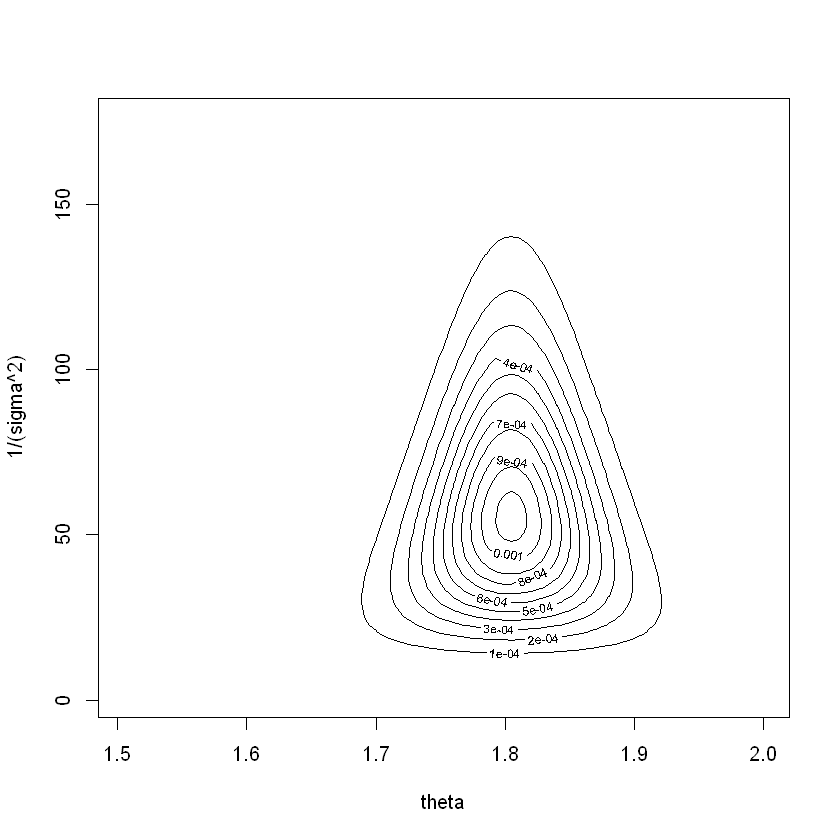

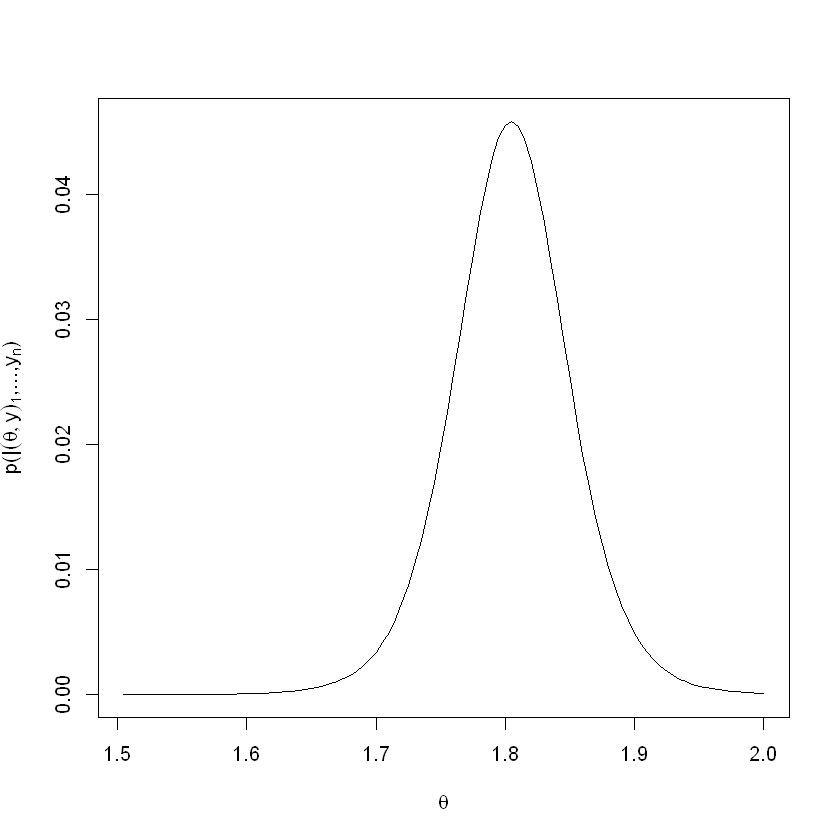

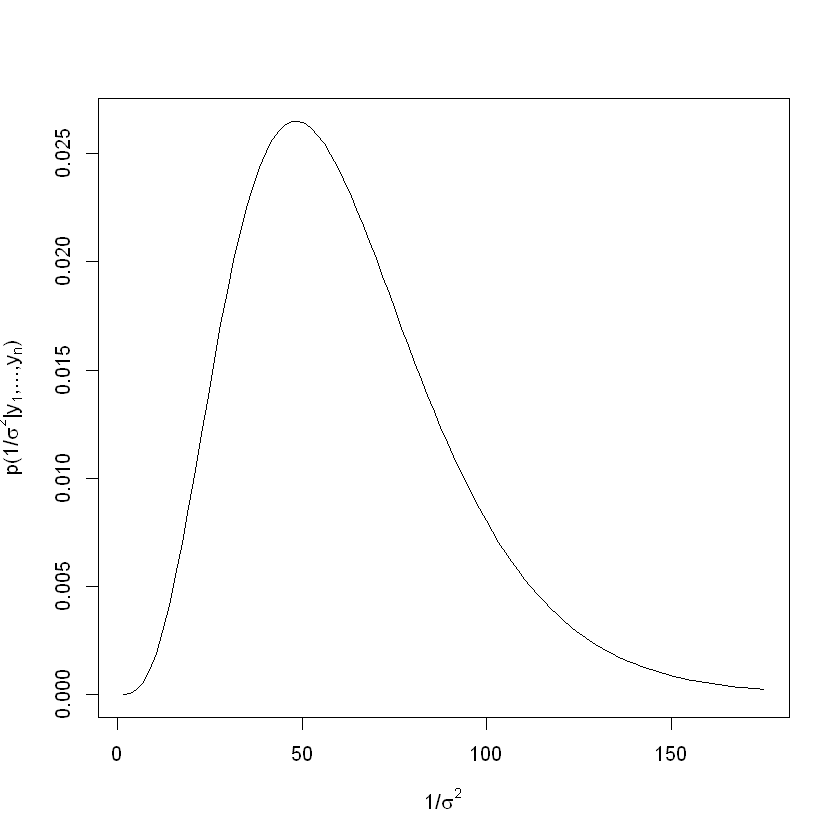

In [38]:
# 画图.
library(ggplot2)
library(ggExtra)

for (g in 1:G) {
    for (h in 1:H) {
        if (g*h == 1){
            lst = c(theta.k.grid[g], inv_sigma2.l.grid[h], p_D.grid[g, h])
        }
        else {
            lst = rbind(lst, c(theta.k.grid[g], inv_sigma2.l.grid[h], p_D.grid[g, h]))
        }
    }
}

# 联合分布.
contour(theta.k.grid, inv_sigma2.l.grid, p_D.grid,xlab="theta", ylab="1/(sigma^2)")

# 边际分布.
library(latex2exp)

plot(theta.k.grid, rowSums(p_D.grid), xlab=TeX("$\\theta$"), ylab=TeX("$p(\\theta|y_1,...,y_n)$"), type='l')
plot(inv_sigma2.l.grid, colSums(p_D.grid), xlab=TeX("$1/\\sigma^2$"), ylab=TeX("$p(1/\\sigma^2|y_1,...,y_n)$"), type='l')

In [39]:
# df = data.frame(lst)
# rownames(df) <- 1:nrow(df)
# names(df) = c("theta", "inv_sigma", "p_D")

# p <- ggplot(df, aes(x=theta, y=inv_sigma)) +
#     geom_point() +
#     theme(legend.position="none")

# p_marginal <- ggMarginal(p, type="histogram")
# p_marginal